### Setup

In [16]:
# !pip install kaggle --upgrade
# !pip install lightgbm
# !pip install catboost
# !pip install dabl
# !pip install plotly
# !pip install shap
# !pip install hyperopt

In [42]:
from tools.setup import *

In [18]:
wkdir = '/home/jovyan/work/analysis/DATASCI-WiDS'
random_state = 33

### Read data

In [19]:
training =  pd.read_csv(wkdir + "/data/TrainingWiDS2021.csv")
data_dictionary = pd.read_csv(wkdir + "/data/DataDictionaryWiDS2021.csv")
training = training.drop(columns=['Unnamed: 0'])

unlabeled = pd.read_csv(wkdir + "/data/UnlabeledWiDS2021.csv")
unlabeled = unlabeled.drop(columns=['Unnamed: 0'])

In [20]:
gc.collect()

66

### Data cleaning

In [21]:
data_types = dabl.detect_types(training)

In [22]:
categoricals = data_types[data_types['categorical']==True].index.tolist()
print("**categorical features**")
print(categoricals)

**categorical features**
['elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_type', 'apache_post_operative', 'intubated_apache', 'ventilated_apache', 'diabetes_mellitus']


In [23]:
continuous = data_types[data_types['continuous']==True].index.tolist()
print("**first 10 continuous features**")
print(continuous[:10])
print("**total continuous features**")
print(len(continuous))

**first 10 continuous features**
['encounter_id', 'age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'bilirubin_apache']
**total continuous features**
157


In [24]:
useless = data_types[data_types['useless']==True].index.tolist()
print("**useless features**")
print(useless)
print("**total useless features**")
print(len(useless))

**useless features**
['icu_stay_type', 'readmission_status', 'arf_apache', 'gcs_unable_apache', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
**total useless features**
11


### Train-test-validate split of labelled data for parameters tunning

**define target** 

In [25]:
target = 'diabetes_mellitus'

**split data: train-validate-test**

In [26]:
# first split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
for train_index, test_index in split.split(training, training[target]):
    strat_train_set = training.loc[train_index]
    strat_test_set = training.loc[test_index]
training['test'] = np.where(training['encounter_id'].isin(strat_test_set['encounter_id']), True, False)
non_test = training.loc[training['test'] == False]
test = training.loc[training['test'] == True]

# second split
train, validate = train_test_split(non_test, test_size=0.2, stratify=non_test[target], random_state=random_state)

In [27]:
print('train : ' + str(train.shape))
print('test : ' + str(test.shape))
print('validate : ' + str(validate.shape))

train : (83300, 181)
test : (26032, 181)
validate : (20825, 181)


**handle missing values by the split above**

In [28]:
## fill NA of numerics with median value
for col in continuous:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)
    validate[col].fillna(validate.median(), inplace=True)  

In [30]:
## fill NAs of categoricals with most common values
categorical_nas = ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source']
train[categorical_nas] = train[categorical_nas].fillna(train.mode().iloc[0])
test[categorical_nas] = test[categorical_nas].fillna(test.mode().iloc[0])
validate[categorical_nas] = validate[categorical_nas].fillna(validate.mode().iloc[0])

print('unique values')
for col in categoricals:
    print(col + ' : ' + str(train[col].unique()))

unique values
elective_surgery : [0 1]
ethnicity : ['Caucasian' 'Other/Unknown' 'African American' 'Asian' 'Hispanic'
 'Native American']
gender : ['F' 'M']
hospital_admit_source : ['Emergency Department' 'Direct Admit' 'Floor' 'PACU' 'Recovery Room'
 'Operating Room' 'Chest Pain Center' 'Acute Care/Floor'
 'Step-Down Unit (SDU)' 'Other Hospital' 'ICU to SDU' 'ICU' 'Other ICU'
 'Other' 'Observation']
icu_admit_source : ['Accident & Emergency' 'Floor' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU']
icu_type : ['CSICU' 'Med-Surg ICU' 'MICU' 'Neuro ICU' 'CCU-CTICU' 'SICU'
 'Cardiac ICU' 'CTICU']
apache_post_operative : [0 1]
intubated_apache : [0 1]
ventilated_apache : [0 1]
diabetes_mellitus : [0 1]


### Features

In [31]:
categoricals.remove(target)
categoricals

['elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_post_operative',
 'intubated_apache',
 'ventilated_apache']

In [32]:
continuous.remove('encounter_id')

In [33]:
model_features = continuous + categoricals

## Model

In [117]:
X_train = train[continuous]
y_train = train[target]
X_test = test[continuous]
y_test = test[target]
X_validate = validate[continuous]
y_validate = validate[target]
print('train')
print(X_train.shape)
print(y_train.value_counts())
print('test')
print(X_test.shape)
print(y_test.value_counts())
print('validate')
print(X_validate.shape)
print(y_validate.value_counts())

train
(83300, 156)
0    65283
1    18017
Name: diabetes_mellitus, dtype: int64
test
(26032, 156)
0    20402
1    5630 
Name: diabetes_mellitus, dtype: int64
validate
(20825, 156)
0    16321
1    4504 
Name: diabetes_mellitus, dtype: int64


### Hyperparameter tuning - hyperopt

In [118]:
import lightgbm as lgb

In [119]:
grid_params = {'model':lgb.LGBMClassifier, 'param': {
    'class_weight': {0:1, 1:hp.uniform('class_weight_1', 90, 450)},
    'min_sum_hessian_in_leaf': hp.uniform('min_sum_hessian_in_leaf', 0.0, 1.0),
    'max_bin': hp.choice('max_bin', np.arange(50, 750, 25, dtype=int)),
    'num_leaves': hp.choice('num_leaves', np.arange(4, 256, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.choice('subsample_for_bin', np.arange(10000, X_train.shape[0], dtype=int)),
    'min_child_samples': hp.choice('min_child_samples', np.arange(20, 500,5, dtype=int)),
    'is_unbalance': hp.choice('is_unbalance', np.array([True, False], dtype = bool)), 
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 1/X_train.shape[1], 1.0),        
    'max_depth': hp.choice('max_depth', np.arange(5, 12,1, dtype=int)),    
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 10.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 10.0),
    'bagging_fraction': hp.uniform('bagging_fraction',1/X_train.shape[0]*10,1.0),
    'bagging_freq': hp.choice('bagging_freq', np.arange(1, 11,1, dtype=int)),
    'objective' : 'binary',
    'boost_from_average': False ,
    'boosting_type': hp.choice('boosting_type', np.array(['gbdt', 'dart'], dtype=str)),
    'n_estimators' : hp.choice('n_estimators', np.arange(200, 5000, 50, dtype=int))
}}   

tested_models =[]
tested_models.append(grid_params)
  
hp_space = hp.choice('classifier',tested_models)

In [120]:
trials = Trials()
max_trials = 10

In [121]:
hyperparameter_set = {}
loss_list = []

def objective(params):
    model = params['model'](**params['param'])
    ## fit model
    model.fit(X_train, y_train)    
    
    ## predict
    pred_test = model.predict(X_test) # class prediction
#     pred_test = pd.DataFrame(model.predict_proba(X_test))#.iloc[:, 1] # probability prediction    
   
    ## evaluate predictions, change score if needed
#     score = roc_auc_score(y_test, pred_test.iloc[:,1])  
#     score = precision_score(y_true=y_test, y_pred=pred_test)
    score = f1_score(y_true=y_test, y_pred=pred_test)
    
    ## define loss
    loss = 1-np.round((score), decimals = 6) 
    hyperparameter_set[loss] = params
    
    print('Loss = ' + str(loss) + '\n')
    loss_list.append(loss)

    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [122]:
%%time
best = fmin(fn = objective, 
            space = hp_space, 
            algo = tpe.suggest, 
            max_evals = max_trials, 
            trials = trials)

Loss = 0.46748500000000004                            

[LightGBM] [Warning]                                                             
feature_fraction is set=0.07385715209952927, colsample_bytree=0.8391525764763766 will be ignored. Current value: feature_fraction=0.07385715209952927
[LightGBM] [Warning]                                                             
lambda_l1 is set=1.6543742631380742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6543742631380742
[LightGBM] [Warning]                                                             
bagging_fraction is set=0.3446694739402648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3446694739402648
[LightGBM] [Warning]                                                             
lambda_l2 is set=4.692972726903593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.692972726903593
[LightGBM] [Warning]                                                             
min_sum_hessian_in_leaf is set=0.11

### Load the best model with the best hyparameters

In [127]:
from hyperopt import space_eval
best_params_hyperopt = space_eval(hp_space, best)['param']
best_params_hyperopt

{'bagging_fraction': 0.9278437351065486,
 'bagging_freq': 9,
 'boost_from_average': False,
 'boosting_type': 'gbdt',
 'class_weight': {0: 1, 1: 415.5324798320063},
 'colsample_bytree': 0.6616924071455909,
 'feature_fraction': 0.5057202614187002,
 'is_unbalance': False,
 'lambda_l1': 1.1035610361541048,
 'lambda_l2': 9.287119306850947,
 'learning_rate': 0.1984964279262592,
 'max_bin': 350,
 'max_depth': 10,
 'min_child_samples': 480,
 'min_sum_hessian_in_leaf': 0.9322887572635592,
 'n_estimators': 3150,
 'num_leaves': 55,
 'objective': 'binary',
 'subsample_for_bin': 48216}

### Fit the model on train+test data 

In [128]:
frames = [X_train, X_test]
X_train_test = pd.concat(frames)
frames = [y_train, y_test]
y_train_test = pd.concat(frames)

In [138]:
%%time
model = lgb.LGBMClassifier( 
  bagging_fraction = 0.9278437351065486,
  bagging_freq = 9,
  boost_from_average = False,
  boosting_type =  'gbdt' ,
  class_weight = {0:1, 1:415.5324798320063},
  colsample_bytree = 0.6616924071455909,
  feature_fraction = 0.5057202614187002,
  is_unbalance = False,
  lambda_l1 = 1.1035610361541048,
  lambda_l2 = 9.287119306850947,
  learning_rate = 0.1984964279262592,
  max_bin = 350,
  max_depth = 10,
  min_child_samples = 480,
  min_sum_hessian_in_leaf = 0.9322887572635592,
  n_estimators = 3150,
  num_leaves = 55,
  objective =  'binary',
  subsample_for_bin = 48216)

model.fit(X_train_test, np.ravel(y_train_test), eval_set = (X_validate, np.ravel(y_validate)))

[LightGBM] [Warning] feature_fraction is set=0.5057202614187002, colsample_bytree=0.6616924071455909 will be ignored. Current value: feature_fraction=0.5057202614187002
[LightGBM] [Warning] lambda_l1 is set=1.1035610361541048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1035610361541048
[LightGBM] [Warning] bagging_fraction is set=0.9278437351065486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9278437351065486
[LightGBM] [Warning] lambda_l2 is set=9.287119306850947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.287119306850947
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.9322887572635592, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.9322887572635592
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[1]	valid_0's binary_logloss: 0.820676
[2]	valid_0's binary_logloss: 0.943867
[3]	valid_0's binary_logloss: 1.04544
[4]	valid_0's binary_logl

LGBMClassifier(bagging_fraction=0.9278437351065486, bagging_freq=9,
               boost_from_average=False, boosting_type='gbdt',
               class_weight={0: 1, 1: 415.5324798320063},
               colsample_bytree=0.6616924071455909,
               feature_fraction=0.5057202614187002, importance_type='split',
               is_unbalance=False, lambda_l1=1.1035610361541048,
               lambda_l2=9.287119306850947, learning_rate=0.1984964279262592,
               max_bin=350, max_depth=10, min_child_samples=480,
               min_child_weight=0.001, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.9322887572635592, n_estimators=3150,
               n_jobs=-1, num_leaves=55, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=48216, subsample_freq=0)

### Model evaluation on X_train_test/X_validate 

In [139]:
predictions_train =  model.predict_proba(X_train_test)[:, 1]
predictions_valid =  model.predict_proba(X_validate)[:, 1]

In [140]:
predictions_test =  model.predict_proba(X_test)[:, 1]

**Confusion matrix**

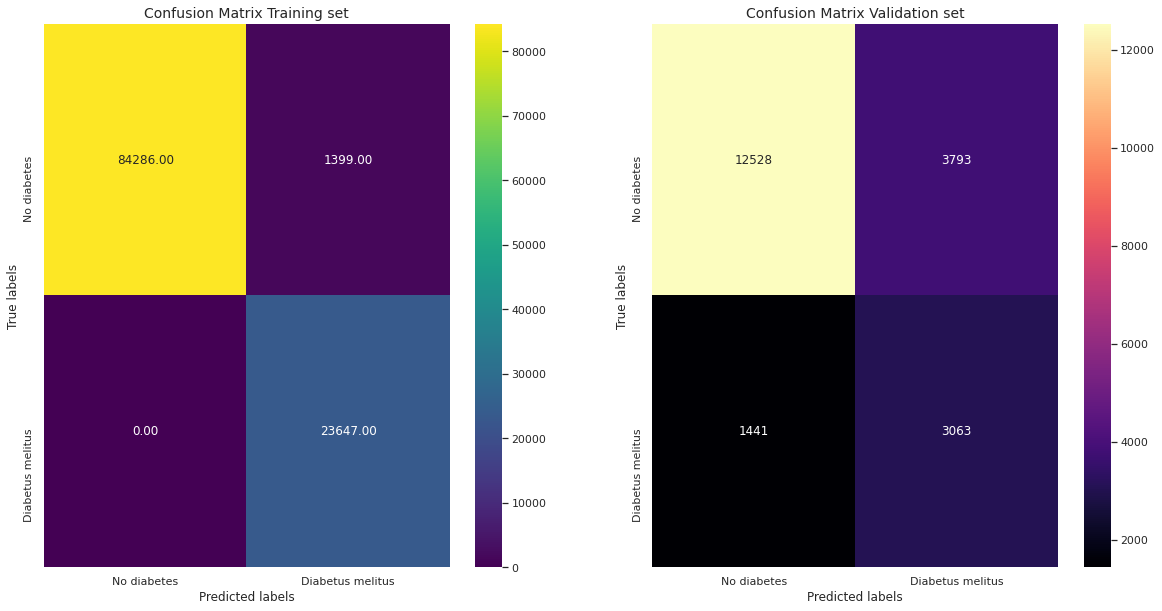

In [151]:
gc.collect()
sns.set(rc={'figure.figsize': (20, 10)})

## cm train+test set
y_pred_train = model.predict(X_train_test)
cm = confusion_matrix(y_train_test, y_pred_train)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ax1 = plt.subplot(1, 2, 1)
# sns.heatmap(cm, annot=True, ax=ax1, fmt='.0f', cmap='magma')
# #annot=True to annotate cells

# # labels, title and ticks
# ax1.set_xlabel('Predicted labels')
# ax1.set_ylabel('True labels')
# ax1.set_title('Confusion Matrix Training')
# ax1.xaxis.set_ticklabels(['No diabetes', 'Diabetus melitus'])
# ax1.yaxis.set_ticklabels(['No diabetes', 'Diabetus melitus'])


ax2 = plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, ax=ax2, fmt='.2f', cmap='viridis')
#annot=True to annotate cells

# labels, title and ticks
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix Training set', size = 14)
ax2.xaxis.set_ticklabels(['No diabetes', 'Diabetus melitus'])
ax2.yaxis.set_ticklabels(['No diabetes', 'Diabetus melitus'])


## cm validation set
y_pred_validate = model.predict(X_validate)
cm = confusion_matrix(y_validate, y_pred_validate)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax1 = plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, ax=ax1, fmt='.0f', cmap='magma')
#annot=True to annotate cells

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title('Confusion Matrix Validation set', size = 14)
ax1.xaxis.set_ticklabels(['No diabetes', 'Diabetus melitus'])
ax1.yaxis.set_ticklabels(['No diabetes', 'Diabetus melitus'])

plt.show()

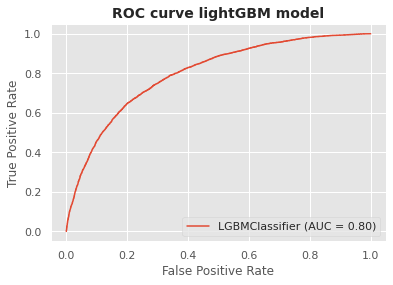

In [161]:
plt.style.use('ggplot')
metrics.plot_roc_curve(model, X_validate, y_validate)
plt.title('ROC curve lightGBM model', fontsize=14, weight="bold")
plt.show()

In [152]:
from sklearn.metrics import classification_report
print(classification_report(y_validate, model.predict(X_validate)))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83     16321
           1       0.45      0.68      0.54      4504

    accuracy                           0.75     20825
   macro avg       0.67      0.72      0.68     20825
weighted avg       0.80      0.75      0.76     20825



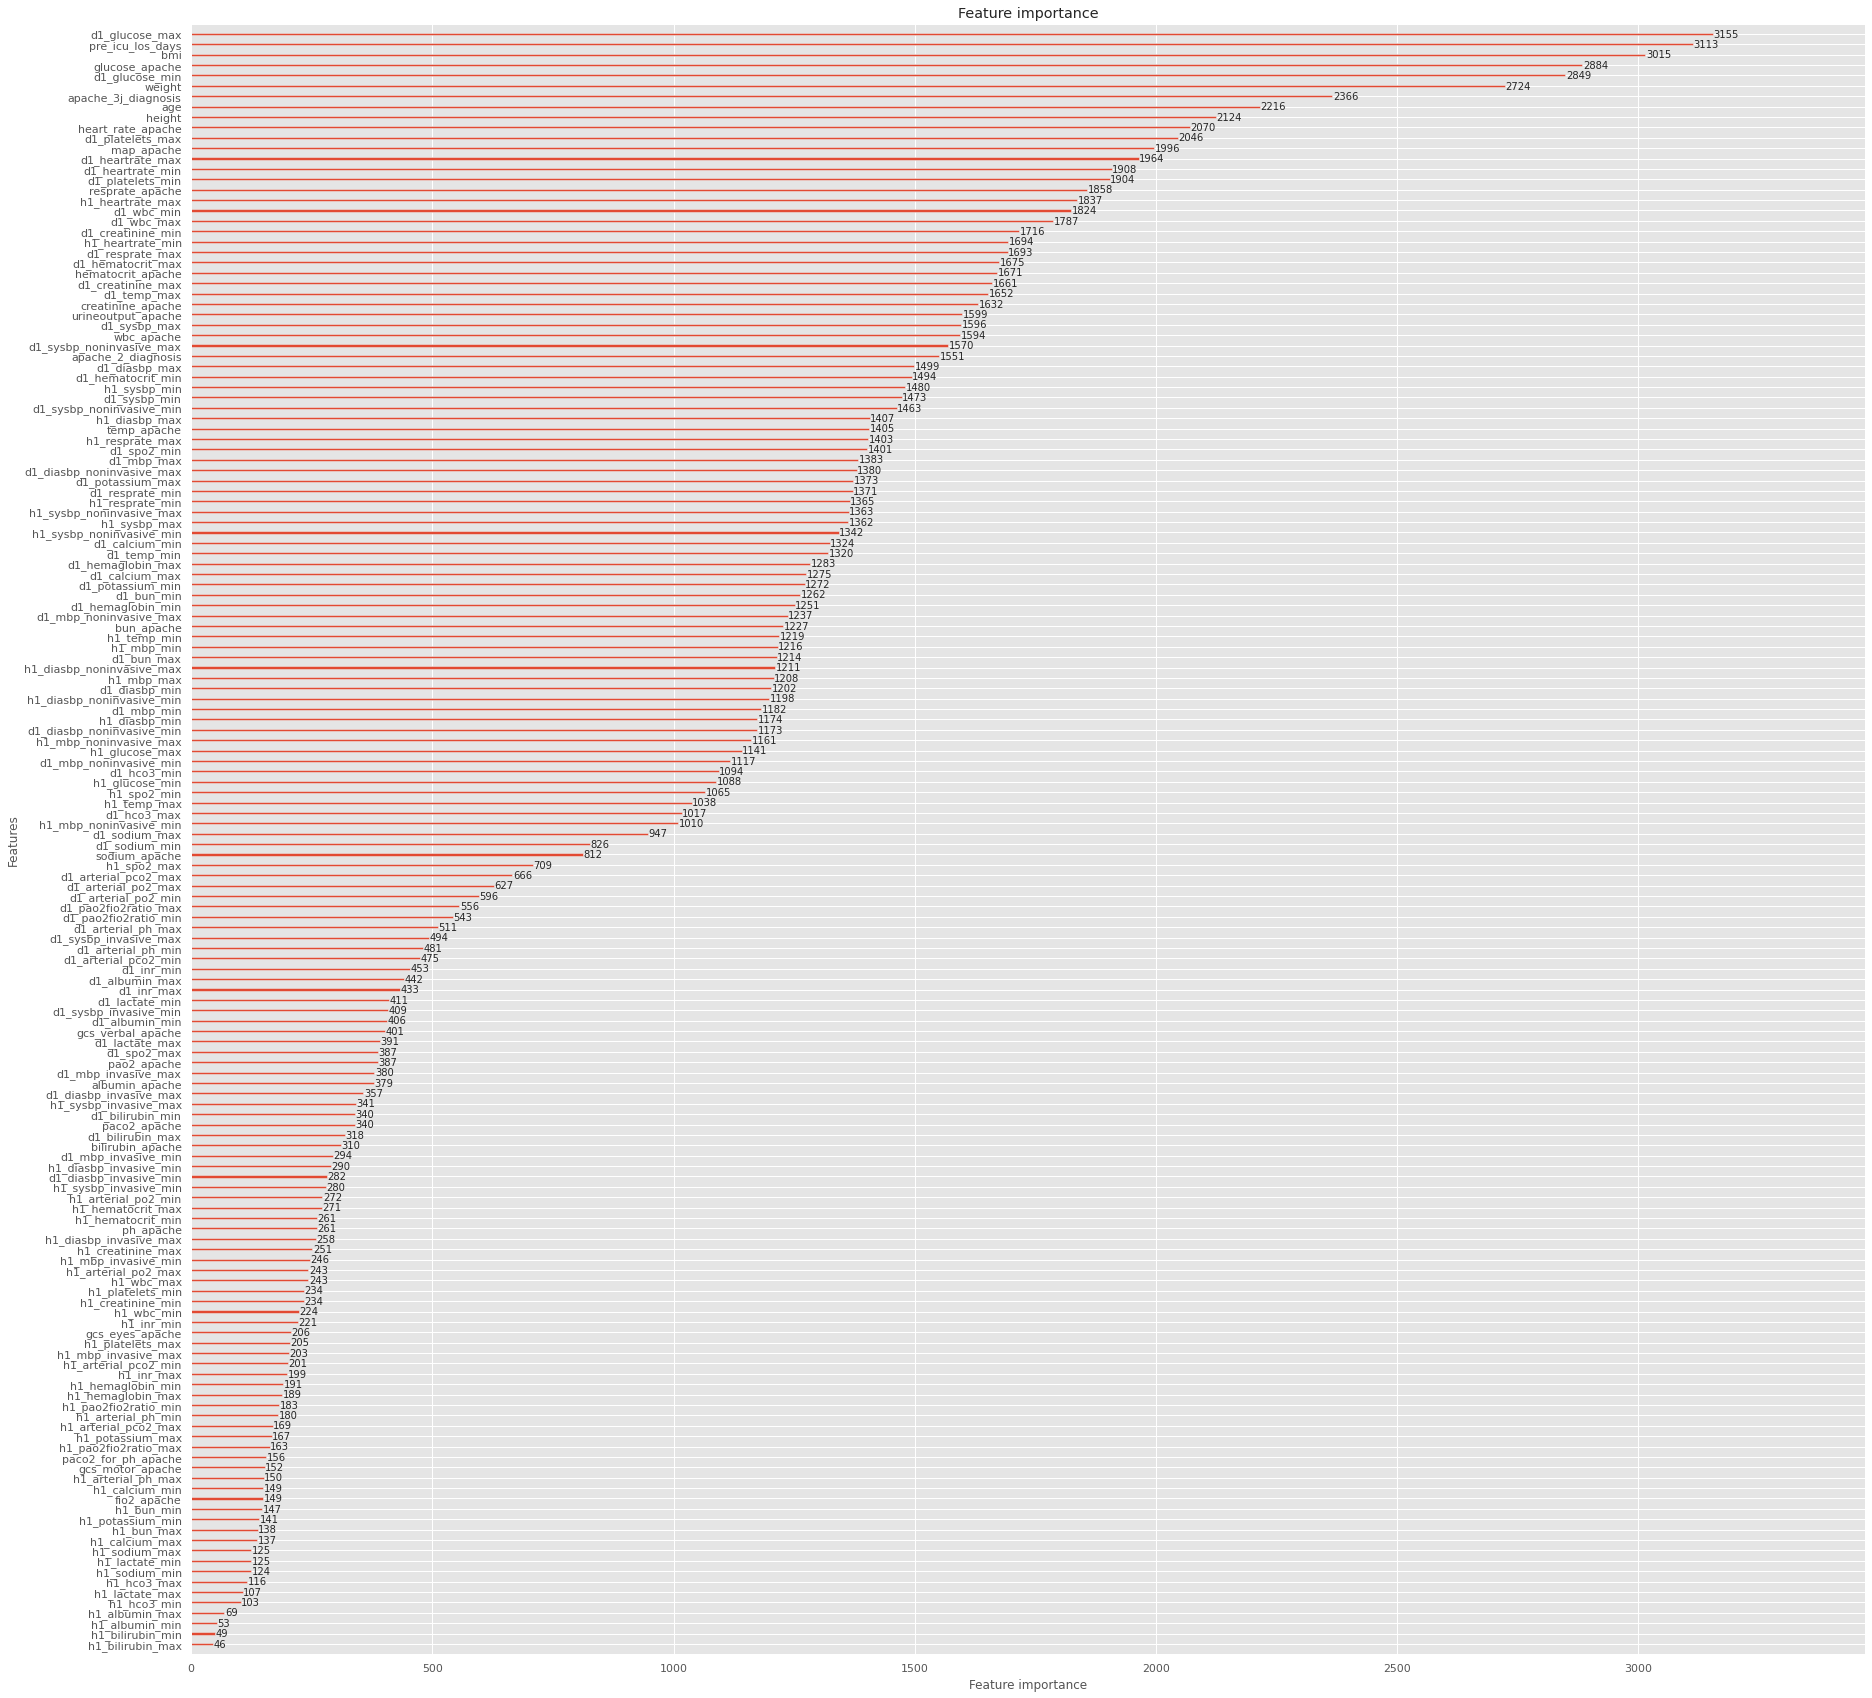

In [159]:
lgb.plot_importance(model, figsize=(30, 30))
plt.show()

### Retrain on all data

In [162]:
frames = [X_train, X_test, X_validate]
X = pd.concat(frames)
frames = [y_train, y_test, y_validate]
y = pd.concat(frames)

In [164]:
%%time

model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.5057202614187002, colsample_bytree=0.6616924071455909 will be ignored. Current value: feature_fraction=0.5057202614187002
[LightGBM] [Warning] lambda_l1 is set=1.1035610361541048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1035610361541048
[LightGBM] [Warning] bagging_fraction is set=0.9278437351065486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9278437351065486
[LightGBM] [Warning] lambda_l2 is set=9.287119306850947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.287119306850947
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.9322887572635592, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.9322887572635592
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
CPU times: user 9min 40s, sys: 1.31 s, total: 9min 41s
Wall time: 36.8 s


LGBMClassifier(bagging_fraction=0.9278437351065486, bagging_freq=9,
               boost_from_average=False, boosting_type='gbdt',
               class_weight={0: 1, 1: 415.5324798320063},
               colsample_bytree=0.6616924071455909,
               feature_fraction=0.5057202614187002, importance_type='split',
               is_unbalance=False, lambda_l1=1.1035610361541048,
               lambda_l2=9.287119306850947, learning_rate=0.1984964279262592,
               max_bin=350, max_depth=10, min_child_samples=480,
               min_child_weight=0.001, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.9322887572635592, n_estimators=3150,
               n_jobs=-1, num_leaves=55, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=48216, subsample_freq=0)

### Predict on unlabelled data

In [166]:
unlabeled[continuous].head()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,72,NaN,152.40,0.02,NaN,2.80,110.00,104.01,1.90,44.00,1.49,NaN,4.00,6.00,5.00,97.00,38.00,39.90,54.00,NaN,NaN,NaN,NaN,31.00,130.00,36.40,NaN,5.40,NaN,NaN,104.00,40.00,104.00,40.00,66.00,38.00,NaN,NaN,123.00,54.00,123.00,54.00,35.00,15.00,100.00,96.00,NaN,NaN,149.00,76.00,149.00,76.00,38.70,35.60,NaN,NaN,59.00,59.00,59.00,59.00,46.00,44.00,NaN,NaN,80.00,80.00,80.00,80.00,19.00,19.00,97.00,96.00,NaN,NaN,116.00,116.00,116.00,116.00,36.40,36.40,2.80,2.80,1.90,1.90,44.00,40.00,9.80,9.30,1.49,1.44,104.00,97.00,26.00,23.00,14.50,14.20,42.80,39.90,NaN,NaN,NaN,NaN,173.00,173.00,5.70,4.90,132.00,130.00,5.60,5.40,2.80,2.80,1.90,1.90,40.00,40.00,9.80,9.80,1.49,1.49,104.00,104.00,26.00,26.00,14.50,14.50,42.80,42.80,NaN,NaN,NaN,NaN,173.00,173.00,4.90,4.90,132.00,132.00,5.60,5.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86,NaN,175.30,0.00,NaN,NaN,117.00,106.01,NaN,19.00,0.92,NaN,4.00,6.00,5.00,73.00,116.00,NaN,41.00,NaN,NaN,NaN,NaN,53.00,142.00,36.30,NaN,NaN,NaN,NaN,101.00,27.00,101.00,27.00,116.00,56.00,NaN,NaN,129.00,41.00,129.00,41.00,51.00,14.00,100.00,95.00,NaN,NaN,181.00,65.00,181.00,65.00,36.80,36.40,NaN,NaN,85.00,65.00,85.00,65.00,116.00,104.00,NaN,NaN,129.00,94.00,129.00,94.00,31.00,24.00,97.00,95.00,NaN,NaN,181.00,119.00,181.00,119.00,36.70,36.70,NaN,NaN,NaN,NaN,19.00,19.00,8.50,8.50,1.00,1.00,102.00,73.00,27.00,27.00,NaN,NaN,NaN,NaN,2.20,2.20,NaN,NaN,NaN,NaN,3.90,3.80,144.00,144.00,NaN,NaN,NaN,NaN,NaN,NaN,N

In [171]:
predicted_probs = pd.DataFrame(model.predict_proba(unlabeled[continuous])[:, 1])
# predicted_labels = pd.DataFrame(model.predict(unlabeled[model_features]))

In [172]:
result = unlabeled['encounter_id'].to_frame()
result[target] = predicted_probs

In [173]:
result = result.reset_index(drop=True)

In [174]:
result

,encounter_id,diabetes_mellitus
0,144740,0.01
1,141990,0.22
2,142038,0.02
3,138628,0.07
4,141682,0.18
...,...,...
10229,143750,0.01
10230,143813,0.05
10231,137126,0.00
10232,135652,0.00


In [175]:
result.to_csv('/home/jovyan/work/analysis/DATASCI-WiDS/submissions/submission_lgb_hyperopt_19022021.csv', index=False)

### Submit to kaggle

In [59]:
# !pip install kaggle --upgrade

In [176]:
!kaggle competitions submit -c widsdatathon2021 -f '/home/jovyan/work/analysis/DATASCI-WiDS/submissions/submission_lgb_hyperopt_19022021.csv' -m "lightGBM hyperopt nums"

100%|████████████████████████████████████████| 273k/273k [00:05<00:00, 50.3kB/s]
Successfully submitted to WiDS Datathon 2021

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code."></form>''')